## Honey Data Challenge: Analysis
Data Analyst Intern 2020 Application

Tiffany Hsu

This notebook includes extensive data analysis on Honey's data with Sephora's coupon codes. Featured sections:
1. Feature Engineering
2. Exploratory Analysis
3. Business Impact & Reach Analysis
4. Product Performance Analysis & Recommendations

In [168]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.formula.api import ols
from pingouin import welch_anova, read_dataset, pairwise_gameshowell
import seaborn as sns
import scikit_posthocs as sp

import warnings
warnings.filterwarnings('ignore')

In [206]:
data = pd.read_excel('Data.xlsx', parse_dates=True)
data.set_index('Date', inplace=True)
data2 = data[data.index >= '2018-09-01']
data2.sort_index(inplace=True)

### Feature Engineering

In [207]:
data2['Money Saved'] = data2['Cart Start Price'] - data2['Cart Final Price']
data2['Save Cost Ratio'] = data2['Money Saved'] / data2['Cart Start Price']
data2['Commission Percent'] = data2['Commission'] / data2['Cart Final Price']
data2['Month'] = data2.index.month
data2['DayofWeek'] = data2.index.day_name()

### Exploratory Analysis, Initial Concerns

In [33]:
print(data2.shape)
data2.head()

(20392, 15)


,User ID,State,OS Name,Browser Name,Cart Start Price,Cart Final Price,Best Code,Code Run Duration,Commission,Money Saved,Save Cost Ratio,Commission Percent,Month,DayofWeek,isCommission
Date,,,,,,,,,,,,,,,
2018-09-01,7705521623914710016,AL,Mac OS X,Chrome,357.0,303.45,YESVIB,10,0.00,53.55,0.15,0.000000,9,Saturday,0
2018-09-01,7989330919754720256,MN,Mac OS X,Chrome,20.0,18.00,YESINSIDER,7,0.00,2.00,0.10,0.000000,9,Saturday,0
2018-09-01,8027167482765960192,FL,Windows,Chrome,55.0,49.50,YESINSIDER,11,2.47,5.50,0.10,0.049899,9,Saturday,1
2018-09-01,8040064411977960448,FL,Windows,Chrome,106.0,95.40,YESINSIDER,28,0.00,10.60,0.10,0.000000,9,Saturday,0
2018-09-01,7993701794348250112,TX,Windows,Chrome,373.0,298.40,YESROUGE,15,0.00,74.60,0.20,0.000000,9,Saturday,0


### Strange Behavior in Daily Data

Text(0.5, 1.0, 'Daily Coupon Code Uses')

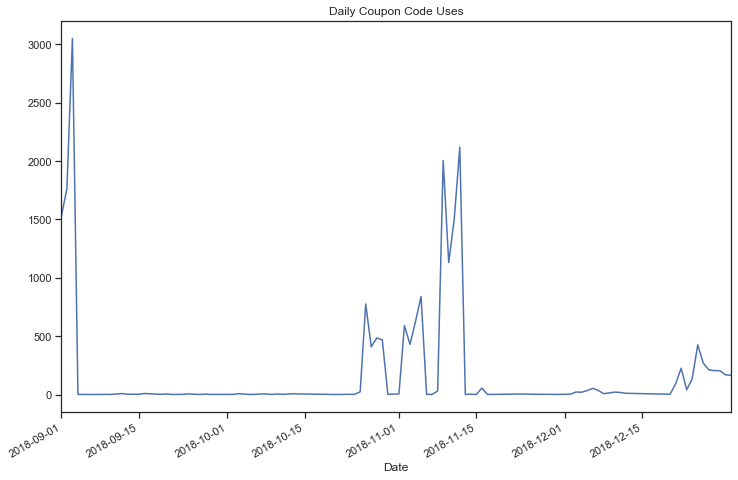

In [100]:
data2.groupby(data2.index).count()['User ID'].plot(figsize=(12,8))
plt.title('Daily Coupon Code Uses')

Coupon use spikes to really high numbers randomly in months, then drop to nearly zero code uses on a daily level. Strangely enough, numbers do not spike during Black Friday (Nov 25ish), but they spike in mid November, which does not make sense in retail trends. 

In [73]:
daily = data2.groupby(data2.index).count()
daily.head()

,User ID,State,OS Name,Browser Name,Cart Start Price,Cart Final Price,Best Code,Code Run Duration,Commission,Money Saved,Save Cost Ratio,Commission Percent,Month,DayofWeek,isCommission
Date,,,,,,,,,,,,,,,
2018-09-01,1528,1528,1528,1528,1528,1528,1528,1528,1528,1528,1528,1528,1528,1528,1528
2018-09-02,1762,1762,1762,1762,1762,1762,1762,1762,1762,1762,1762,1762,1762,1762,1762
2018-09-03,3051,3051,3051,3051,3051,3051,3051,3051,3051,3051,3051,3051,3051,3051,3051
2018-09-04,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
2018-09-05,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [67]:
data2.groupby(data2.index).count()['User ID'].describe()

count      97.000000
mean      210.226804
std       519.457780
min         1.000000
25%         2.000000
50%         5.000000
75%        91.000000
max      3051.000000
Name: User ID, dtype: float64

#### September

Text(0.5, 1.0, 'Sept Daily Coupon Code Uses')

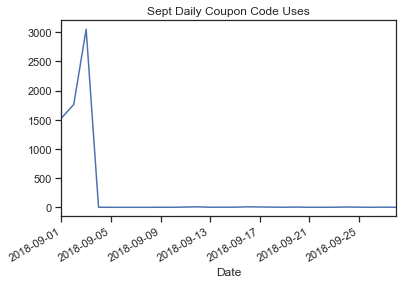

In [101]:
daily[(daily.index >= '2018-09-01') &( daily.index < '2018-10-01') ]['User ID'].plot()
plt.title('Sept Daily Coupon Code Uses')

In [93]:
print('Code uses in first 3 days of September:',daily[daily.index<='2018-09-04']['User ID'].sum())
print('Code uses in remaining days of September:',daily[(daily.index>='2018-09-05') & (daily.index<'2018-10-01')]['User ID'].sum())
print('% of total use from first 3 days:', 61/(61+6343))

Code uses in first 3 days of September: 6343
Code uses in remaining days of September: 61
% of total use from first 3 days: 0.009525296689569019


In [82]:
monthly = data2.groupby(data2['Month']).count()['User ID']
monthly

Month
9     6404
10    2236
11    9362
12    2390
Name: User ID, dtype: int64

Right away, I notice that the first 3 days of September have EXTREMELY high coupon uses in comparison to daily uses in the rest of the year. To figure out whether or not this has been miscalculated sum of the whole month's coupon uses, I have figured out the coupon uses per month from September - December. From above, it is clear that while 6404 code uses is a high number, it is certainly possible, as November achieved 9362 uses. 

From this investigation, I can reasonably assume that most of the coupon uses for September were wrongly summed into the first 3 days of the month. Specifically, 99% of the entire month's code frequency was within the first 3 days.

#### October

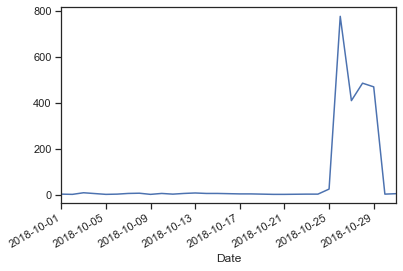

In [97]:
daily[(daily.index >= '2018-10-01') &( daily.index < '2018-11-01') ]['User ID'].plot()

In [92]:
print('Code uses in 10/27 - 10/29:', daily[(daily.index>='2018-10-26') & (daily.index<='2018-10-29')]['User ID'].sum())
print('Code uses in remaining days of October:', monthly[10] - daily[(daily.index>='2018-10-26') & (daily.index<='2018-10-29')]['User ID'].sum())
print('% of total use from 10/27 - 10/29:', 97/(97+2139))

Code uses in 10/27 - 10/29: 2139
Code uses in remaining days of October: 97
% of total use from 10/27 - 10/29: 0.04338103756708408


Similarly, in October, I found that 96% of its coupon uses were within a 3 day period out of the entire month. From this, this further proves my suspicion that the coupon tracker is not properly recording on a daily level, but recording multiple uses at random points throughout the month.

#### November

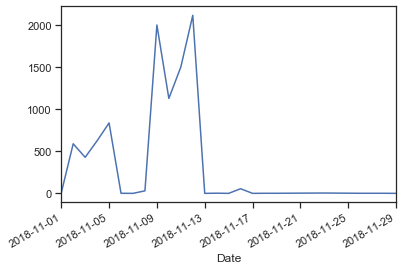

In [95]:
daily[(daily.index >= '2018-11-01') &( daily.index < '2018-12-01') ]['User ID'].plot()

Again, similar behavior in November, except over a period of 6 days rather than 3.

#### December

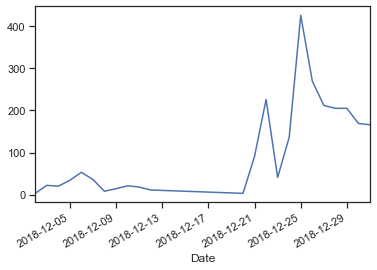

In [96]:
daily[(daily.index >= '2018-12-01')]['User ID'].plot()

December seems to have a slightly more regular distribution of frequencies, but they also dip dangerously low during mid month.

From this analysis, I can reasonably argue that Honey's daily tracking measure is inaccurate. While it may correctly collect all the code use frequencies overall (or by month), on a daily level, they are randomly being pushed to specific days of the month. It is highly unlikely that the first 3 days of a month will take up 99% of code uses, and immediately drop to near 0 values for the rest of the month. Similar behaviors in October & November further my suspicion. Additionally, historically in the retail world, Black Friday usually sets records online & in foot traffic, but there is no indication of such behavior in the data.

### Continuing Exploratory Analysis

In [16]:
data2['Code Run Duration'].describe()

count    20392.000000
mean        15.330767
std         10.757627
min          4.000000
25%         10.000000
50%         12.000000
75%         17.000000
max        540.000000
Name: Code Run Duration, dtype: float64

In [17]:
data2['Money Saved'].describe()

count    20392.000000
mean        24.292797
std         37.375612
min          0.200000
25%          7.500000
50%         14.800000
75%         29.000000
max       2771.200000
Name: Money Saved, dtype: float64

In [18]:
data2['Save Cost Ratio'].describe()

count    20392.000000
mean         0.168460
std          0.053721
min          0.001035
25%          0.150000
50%          0.200000
75%          0.200000
max          1.000000
Name: Save Cost Ratio, dtype: float64

#### Checking for NA

In [19]:
data2.isnull().sum()

User ID                  0
State                    0
OS Name                  0
Browser Name             0
Cart Start Price         0
Cart Final Price         0
Best Code                0
Code Run Duration        0
Commission            9586
Money Saved              0
Save Cost Ratio          0
Commission Percent    9587
Month                    0
DayofWeek                0
dtype: int64

Since Honey makes no commission from the NA's I will replace them with zeros.

In [20]:
data2.fillna(0, inplace=True)

In [21]:
data2.isnull().sum()

User ID               0
State                 0
OS Name               0
Browser Name          0
Cart Start Price      0
Cart Final Price      0
Best Code             0
Code Run Duration     0
Commission            0
Money Saved           0
Save Cost Ratio       0
Commission Percent    0
Month                 0
DayofWeek             0
dtype: int64

In [208]:
data2['isCommission'] = 0
def comm(row):
    if row['Commission'] > 1:
        return 1
    else:
        return 0
data2['isCommission'] = data2.apply(lambda row: comm(row), axis=1)

## Business Impact & Reach Analysis
Topics covered:
- Commission change over time, on a monthly level & day of week
- Seasonality in regards to following the retail cycle
- Commissioned codes vs. non commissioned codes and their effect on business profits & customer impact
- Popularity in States

#### Monthly Analysis

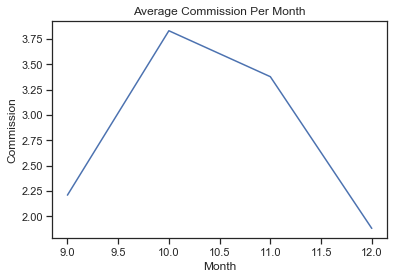

In [14]:
savings_by_month = data2.groupby('Month')
means3 = savings_by_month.mean()
plt.plot(means3['Commission'], linestyle='-')
plt.xlabel(means3.index.name)
plt.ylabel('Commission')
plt.title('Average Commission Per Month')
plt.show()

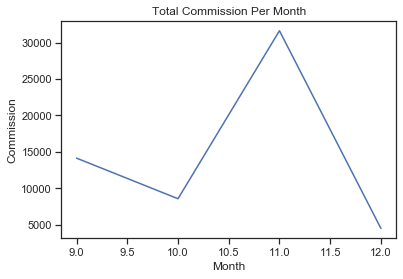

In [15]:
savings_by_month = data2.groupby('Month')
sum1 = savings_by_month.sum()
plt.plot(sum1['Commission'], linestyle='-')
plt.xlabel(sum1.index.name)
plt.ylabel('Commission')
plt.title('Total Commission Per Month')
plt.show()

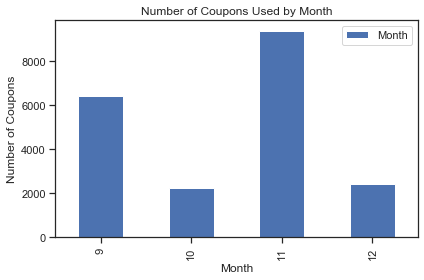

In [16]:
m = pd.DataFrame(data2["Month"].value_counts())
m.sort_index(inplace=True)

m.plot.bar()
plt.xlabel("Month")
plt.ylabel("Number of Coupons")
plt.title("Number of Coupons Used by Month")
plt.tight_layout()
plt.margins(0.05)

Even though the most codes were used in November, October had the highest average commission, meaning that in October, Honey on average made more money off each user's order. Unsurprisingly, November had the highest number of coupon code users, because that is the peak of the holiday shopping period.

In [196]:
one_hot = pd.get_dummies(data2['isCommission'])
data2 = data2.join(one_hot)

In [40]:
com_month = data2.groupby('Month')
sum_month = com_month.sum()

In [44]:
sum_month = sum_month/1000000

Text(0, 0.5, 'Number of Coupons (millions)')

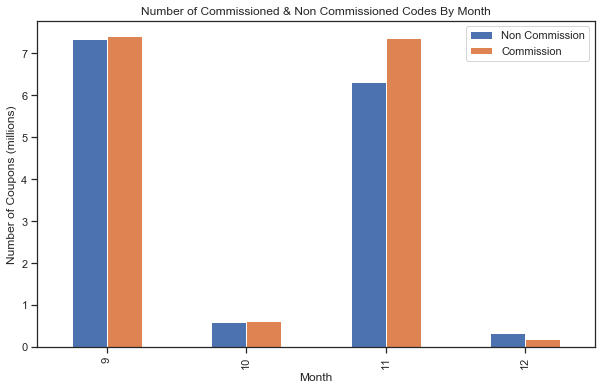

In [46]:
sum_month.plot(y=[0,1], kind="bar", figsize=(10,6))
L=plt.legend()
L.get_texts()[0].set_text('Non Commission')
L.get_texts()[1].set_text('Commission')
plt.title('Number of Commissioned & Non Commissioned Codes By Month')
plt.ylabel('Number of Coupons (millions)')

During peak holiday shopping season, November, Honey has more commissioned codes than noncommissioned codes, implying seasonality during this time of the year. After this month has passed, December shows an heavy decrease in coupon code frequencies as well as a more balanced commissioned to non commissioned proportion. Retailers understand the influx of holiday shoppers, and will make more partnerships to ensure more attractive sales to entice customers during this time of the year. 

We see a similar effect in September, where major sales from Labor Day occur. Again, after September passes, there is a huge drop in codes uses in October, as well as a more balanced distribution of commissioned vs non commissioned codes. Coupon code popularity and frequency will fluctuate with the standard retail cycle.

#### Day of Week Analysis

#### Important Notice
It is important to note our previous concerns with the data collection. Since I suspect that records are not being properly recorded on a daily level, it's important to take the week-day & daily level analysis with a grain of salt, as it is possible that the days could be completely wrong.

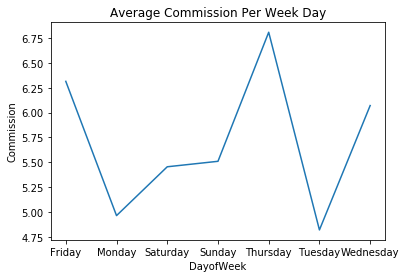

In [8]:
comm_by_day = data2.groupby('DayofWeek')
means2 = comm_by_day.mean()
plt.plot(means2['Commission'], linestyle='-')
plt.xlabel(means2.index.name)
plt.ylabel('Commission')
plt.title('Average Commission Per Week Day')
plt.show()

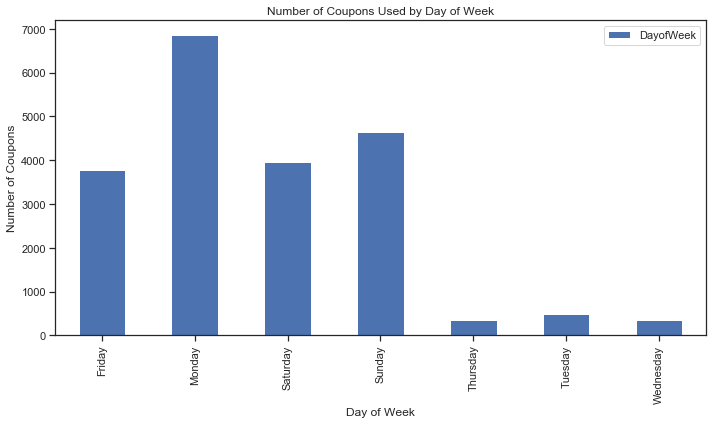

In [17]:
d = pd.DataFrame(data2["DayofWeek"].value_counts())
d.sort_index(inplace=True)

d.plot.bar(figsize=(10,6))
plt.xlabel("Day of Week")
plt.ylabel("Number of Coupons")
plt.title("Number of Coupons Used by Day of Week")
plt.tight_layout()
plt.margins(0.05)

We see a similar effect with days of the week as well, even though most people used coupon codes on Monday, Honey made more average commission on a day with lower frequencies: Thursday. People are shopping more on Friday - Monday.

Text(0.5, 1.0, 'Average Commission by Day')

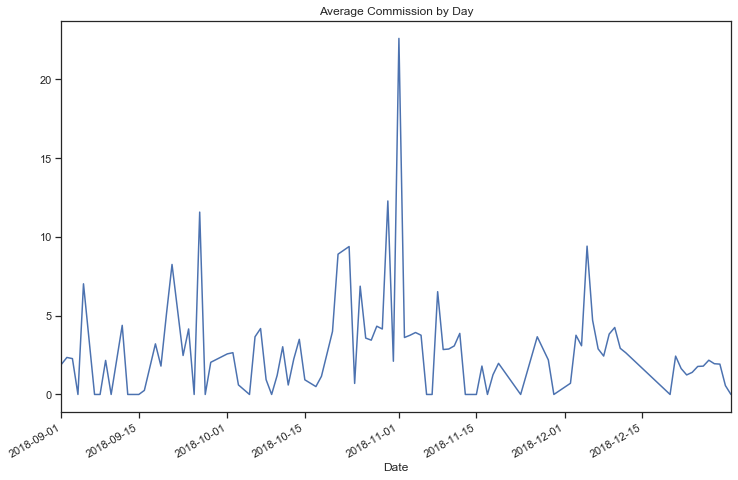

In [102]:
data2.groupby(data2.index).mean()['Commission'].plot(figsize=(12,8))
plt.title('Average Commission by Day')

Clearly, there is seasonality in commission. Every week, users commission will spike up and then shoot back down. This is because online shoppers tend to do more shopping & spend more money during select days of the week and do very little shopping the rest of the week. 

Text(0.5, 1.0, 'Commission Percentage over Time')

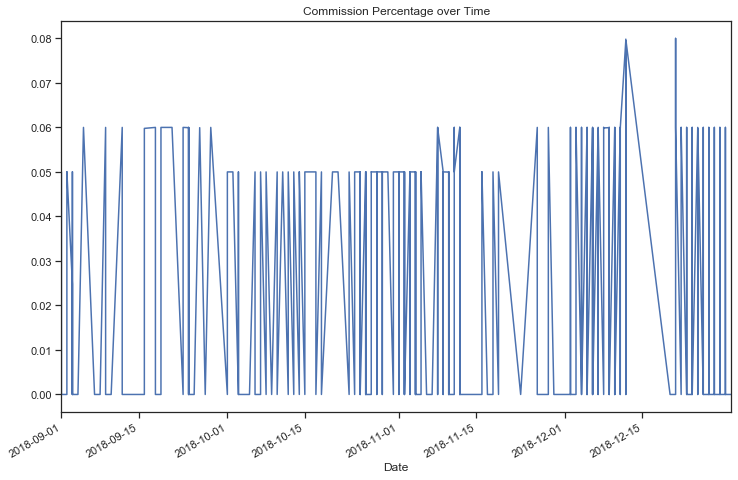

In [18]:
data2['Commission Percent'].plot(figsize=(12,8))
plt.title('Commission Percentage over Time')

From this plot we can see that Honey typically receives commission of 0% - 8%, with averages typically in 5% commission.

#### Commissioned vs Non Commissioned Coupons

In [214]:
data['Cart Start Price'].describe()

count    27714.000000
mean       138.856483
std        188.567148
min          2.000000
25%         54.000000
50%         90.000000
75%        165.000000
max      13856.000000
Name: Cart Start Price, dtype: float64

In [215]:
data['Cart Final Price'].describe()

count    27714.000000
mean       115.098389
std        155.644664
min          0.000000
25%         45.600000
50%         75.650000
75%        136.800000
max      11084.800000
Name: Cart Final Price, dtype: float64

Since both cart start & final prices have extreme outliers, I will use median as my metric for comparison.

Text(0, 0.5, 'Cart Price ($)')

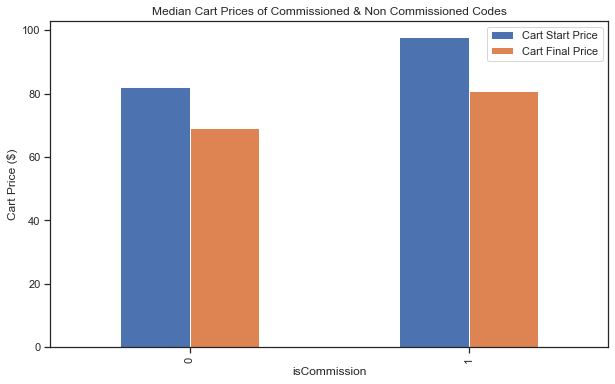

In [213]:
com = data2.groupby('isCommission')
med = com.median()

med.plot( y=['Cart Start Price', 'Cart Final Price'], kind="bar", figsize=(10,6))
L=plt.legend()
L.get_texts()[0].set_text('Cart Start Price')
L.get_texts()[1].set_text('Cart Final Price')
plt.title('Median Cart Prices of Commissioned & Non Commissioned Codes')
plt.ylabel('Cart Price ($)')

In [224]:
data2.groupby('isCommission').median()[['Cart Start Price', 'Cart Final Price']]

,Cart Start Price,Cart Final Price
isCommission,,
0,82.0,69.20
1,98.0,80.75


Commissioned coupons typically cause customers to spend more money. Cart start & final prices are both higher, which makes these commission deals more appealing for the partner.

#### Percentage Saved & Commissioned Coupons Analysis

In [187]:
data2['Save Cost Ratio'].describe()

count    20392.000000
mean         0.168460
std          0.053721
min          0.001035
25%          0.150000
50%          0.200000
75%          0.200000
max          1.000000
Name: Save Cost Ratio, dtype: float64

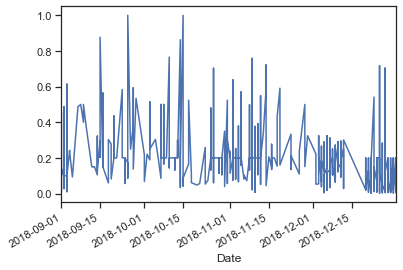

In [127]:
data2['Save Cost Ratio'].plot()

Since there aren't any extreme outliers, I will choose to use the average for comparison purposes. Now, we know that commissioned coupons help the retailer (Sephora) because customers are likely to spend more in their carts, but do these commissioned coupons also help customers save more?

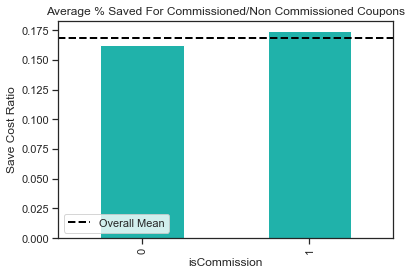

In [129]:
com2 = data2.groupby('isCommission')
com2_mean = com2.mean()
com2_mean['Save Cost Ratio'].plot.bar(color = 'lightseagreen', label='')
plt.axhline(data2['Save Cost Ratio'].mean(), color='black', linewidth=2, linestyle='--', label='Overall Mean')
plt.xlabel(com2_mean.index.name)
plt.ylabel('Save Cost Ratio')
plt.title('Average % Saved For Commissioned/Non Commissioned Coupons')
plt.legend(loc='bottom left')
plt.show()


We will perform a t-test to determine if there is a significant difference in the save cost ratio between commissioned and non commissioned coupon codes.

In [20]:
print('Checking equal var:',com2['Save Cost Ratio'].var()[0] / com2['Save Cost Ratio'].var()[1] )

comm = data2[data2['isCommission'] == 1]['Save Cost Ratio']
noncomm = data2[data2['isCommission'] == 0]['Save Cost Ratio']

stats.ttest_ind(comm,noncomm, equal_var = True)

Checking equal var: 1.6530813979403938


Ttest_indResult(statistic=15.200378142108676, pvalue=6.770320762526869e-52)

In [208]:
# Percentage Penetration
com = data2["isCommission"].value_counts().sort_values(ascending = False)

print('Percentage of Commissioned Coupons out of total', com[1]/sum(com))
print('Percentage of Non Commissioned Coupons out of total', com[0]/sum(com))

Percentage of Commissioned Coupons out of total 0.49764613573950567
Percentage of Non Commissioned Coupons out of total 0.5023538642604943


Commissioned codes provide better savings percentages than non commissioned codes. Thus, we can conclude Honey's partnership coupon codes do significantly benefit the customer while also bringing in more profit. For increased success, Honey should try to increase the number commissioned coupon codes.

#### Product Popularity by State

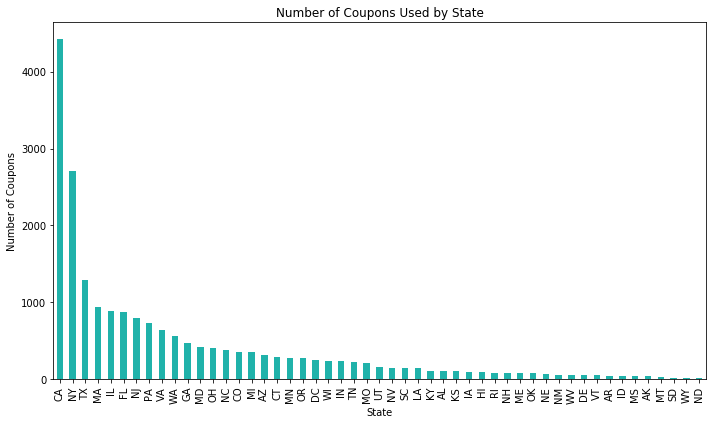

In [40]:
s = data2["State"].value_counts().sort_values(ascending = False)
s.plot.bar(figsize=(10,6), color='lightseagreen')
plt.xlabel("State")
plt.ylabel("Number of Coupons")
plt.title("Number of Coupons Used by State")
plt.tight_layout()
plt.margins(0.05)

Unsurprisingly, Honey's biggest clientbase is in California.

## Product Analysis
Topics covered:

- Code runtime performance across different OS systems
- Code runtime performance across different browsers
- Code runtime performance in commissioned vs non-commissioned coupons
- Product improvement recommendations


#### OS System Code Run Duration Analysis

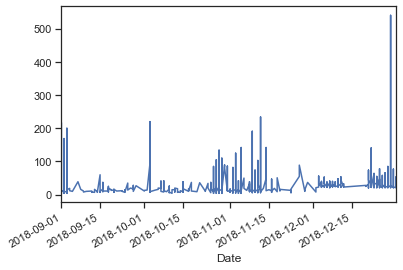

In [153]:
data2['Code Run Duration'].plot()

In [152]:
data2['Code Run Duration'].describe()

count    20392.000000
mean        15.330767
std         10.757627
min          4.000000
25%         10.000000
50%         12.000000
75%         17.000000
max        540.000000
Name: Code Run Duration, dtype: float64

Since there are clearly outliers in code run duration time, we will use median for analysis.

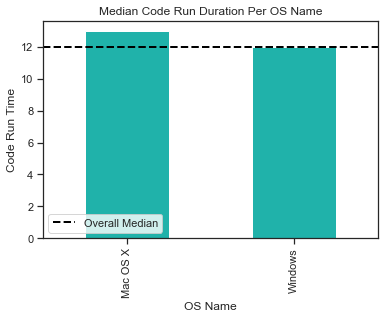

In [151]:
sys = data2.groupby('OS Name')
sys_means = sys.median()
sys_means['Code Run Duration'].plot.bar(color = 'lightseagreen', label='')
plt.axhline(data2['Code Run Duration'].median(), color='black', linewidth=2, linestyle='--', label='Overall Median')
plt.xlabel(sys_means.index.name)
plt.ylabel('Code Run Time')
plt.title('Median Code Run Duration Per OS Name')
plt.legend(loc=3)
plt.show()

The dashed line represents the overall median run time across both OS systems. To determine if there is a significant difference between the median run times across the two os systems, we will run the Kruskal-Wallis H-test. 

Null hypothesis: The median run times between the OS systems are the same.

In [158]:
mac = data2[data2['OS Name'] == 'Mac OS X']['Code Run Duration']
win = data2[data2['OS Name'] == 'Windows']['Code Run Duration']

stats.kruskal(mac,win)

KruskalResult(statistic=5.0914059107394865, pvalue=0.02404469111467545)

From the results of the kruskal test, the low pvalue indicates that there is a significant difference between the median runtimes in the OS systems.

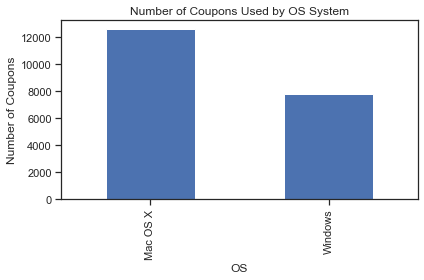

In [26]:
os = data2["OS Name"].value_counts().sort_values(ascending = False)
os.plot.bar()
plt.xlabel("OS")
plt.ylabel("Number of Coupons")
plt.title("Number of Coupons Used by OS System")
plt.tight_layout()
plt.margins(0.05)

In [127]:
print('Percentage of Mac Users out of total', os['Mac OS X']/sum(os))
print('Percentage of Windows Users out of total', os['Windows']/sum(os))

Percentage of Mac Users out of total 0.6187230286386818
Percentage of Windows Users out of total 0.38127697136131816


I would recommend to focus more efforts on improving code run time on Mac OS systems to improve the overall performance with consistency, especially since Mac users take up almost 60% of the overall userbase. It's interesting to note that on average, Macs have better run times, but they have higher median run times.

#### Browser Code Run Time Analysis

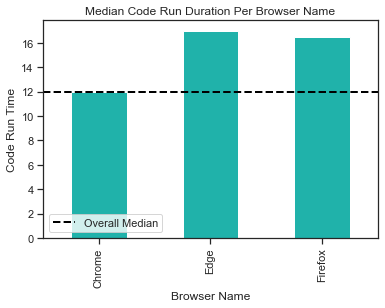

In [165]:
sys = data2.groupby('Browser Name')
sys_means = sys.median()
sys_means['Code Run Duration'].plot.bar(color = 'lightseagreen', label='')
plt.axhline(data2['Code Run Duration'].median(), color='black', linewidth=2, linestyle='--', label='Overall Median')
plt.xlabel(sys_means.index.name)
plt.ylabel('Code Run Time')
plt.title('Median Code Run Duration Per Browser Name')
plt.legend(loc=3)
plt.show()

To test whether each type of browser's run time is significantly different from each other, we will perform an ANOVA test. Since we will be comparing medians, we will use Kruskal Wallis Test again. 

In [167]:
stats.kruskal(chrome,edge,firefox)

KruskalResult(statistic=405.9139461144341, pvalue=7.192941653266076e-89)

Since we get a significant p value from this result, we will perform a post hoc test: Dunn's Test.

In [173]:
sp.posthoc_dunn(data2, val_col = 'Code Run Duration', group_col='Browser Name')

,Chrome,Edge,Firefox
Chrome,-1.000000e+00,6.414539e-46,2.736341e-48
Edge,6.414539e-46,-1.000000e+00,8.534680e-03
Firefox,2.736341e-48,8.534680e-03,-1.000000e+00


By the looks of the pvalues in each of the browser pairwise comparisons, we can conclude that the median code run durations are all significantly different from each other.

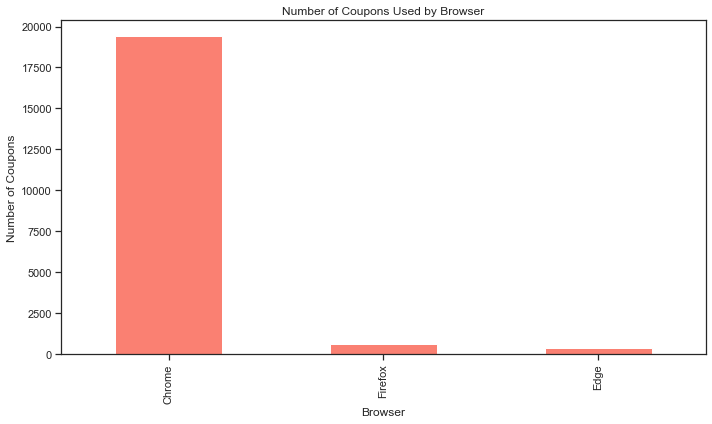

In [28]:
b = data2["Browser Name"].value_counts().sort_values(ascending = False)
b.plot.bar(figsize=(10,6), color = 'salmon')
plt.xlabel("Browser")
plt.ylabel("Number of Coupons")
plt.title("Number of Coupons Used by Browser")
plt.tight_layout()
plt.margins(0.05)

In [123]:
# Percent penetration
print('Percentage of Chrome Users out of total', b['Chrome']/sum(b))
print('Percentage of Firefox Users out of total', b['Firefox']/sum(b))
print('Percentage of Edge Users out of total', b['Edge']/sum(b))

Percentage of Chrome Users out of total 0.9515986661435857
Percentage of Firefox Users out of total 0.03109062377402903
Percentage of Edge Users out of total 0.017310710082385248


Both Edge & Firefox are have run times that are significantly higher from the overall run time. Thus, to make the product faster overall, Honey should focus more efforts on improving the run times of these browsers. Of Firefox and Edge, Honey should spend more time improving Firefox performance because its userbase is almost 3x of those using Edge.

#### Commission vs Non Commissioned Code Run Time Analysis

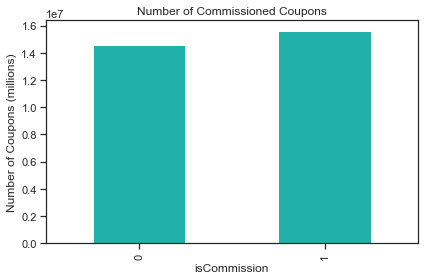

In [56]:
com = data2["isCommission"].value_counts().sort_values(ascending=True)
com.plot.bar( color='lightseagreen')
plt.xlabel("isCommission")
plt.ylabel("Number of Coupons (millions)")
plt.title("Number of Commissioned Coupons")
plt.tight_layout()
plt.margins(0.05)

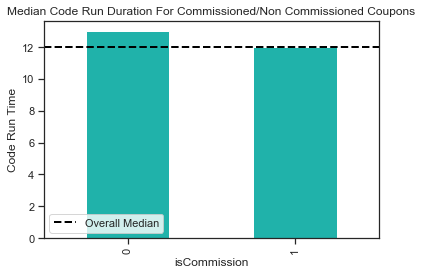

In [181]:
com2 = data2.groupby('isCommission')
com2_mean = com2.median()
com2_mean['Code Run Duration'].plot.bar(color = 'lightseagreen', label='')
plt.axhline(data2['Code Run Duration'].median(), color='black', linewidth=2, linestyle='--', label='Overall Median')
plt.xlabel(com2_mean.index.name)
plt.ylabel('Code Run Time')
plt.title('Median Code Run Duration For Commissioned/Non Commissioned Coupons')
plt.legend(loc=3)
plt.show()

Again, we will check for significant differences using Kruskal's Test.

In [180]:
comm = data2[data2['isCommission'] == 1]['Code Run Duration']
noncomm = data2[data2['isCommission'] == 0]['Code Run Duration']

stats.kruskal(comm,noncomm)

KruskalResult(statistic=110.50993205795233, pvalue=7.576485920661865e-26)

In [192]:
# Percentage Penetration
print('Percentage of Commissioned Coupons out of total', com[1]/sum(com))
print('Percentage of Non Commissioned Coupons out of total', com[0]/sum(com))

Percentage of Commissioned Coupons out of total 0.49764613573950567
Percentage of Non Commissioned Coupons out of total 0.5023538642604943


It seems like commissioned coupons, when available, are statistically proven to have faster code run durations. To improve overall performance, Honey should run commissioned codes first before running other non commission codes to speed up code run times.

### Product Improvement Recommendations
To optimize product performance in code run duration, I would recommend Honey focus its efforts on improving code run times for Mac OS systems and focus on improving code run durations for Firefox browsers. Additionally, we proved that commissioned codes not only have faster run times, provide better savings percentages, but also yield more customer spending. Thus, to speed up product run time, I would recommend that Honey filters commissioned coupons first to cut down run time.